In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score



In [ ]:
# Formating to datetime
from datetime import datetime
df = pd.read_csv("./cleaned_data.csv")

df['ts']=pd.to_datetime(df['ts'],utc=True)
df = df[['val','ts']]
def is_working_hour(timestamp):
    # Check if it's a weekend (Saturday or Sunday)
    if timestamp.dayofweek >= 5:
        return 0

    # Check if it's after 18:00 or before 09:00
    if timestamp.hour >= 18 or timestamp.hour < 9:
        return 0

    return 1

# df['working_hour'] = df['ts'].apply(is_non_working_hour)

# Sorting the values
df.sort_values('ts', inplace=True)
df.set_index('ts', inplace=True)
df=df.tz_localize(None)


In [ ]:

df = df.sort_index()
# df= df['val'].resample('MS').sum()
total_rows = len(df)
show_later= df.tail(20)
df = df.iloc[:total_rows-20]

y=df
print(y)

                        val
ts                         
2022-11-10 13:00:00  42.108
2022-11-10 14:00:00  40.380
2022-11-10 15:00:00  46.212
2022-11-10 16:00:00  48.084
2022-11-10 17:00:00  39.444
...                     ...
2023-07-15 21:00:00  19.968
2023-07-15 22:00:00  21.240
2023-07-15 23:00:00  21.336
2023-07-16 00:00:00  29.316
2023-07-16 01:00:00  23.040

[5941 rows x 1 columns]


In [ ]:
split_date = '2023-07-01'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

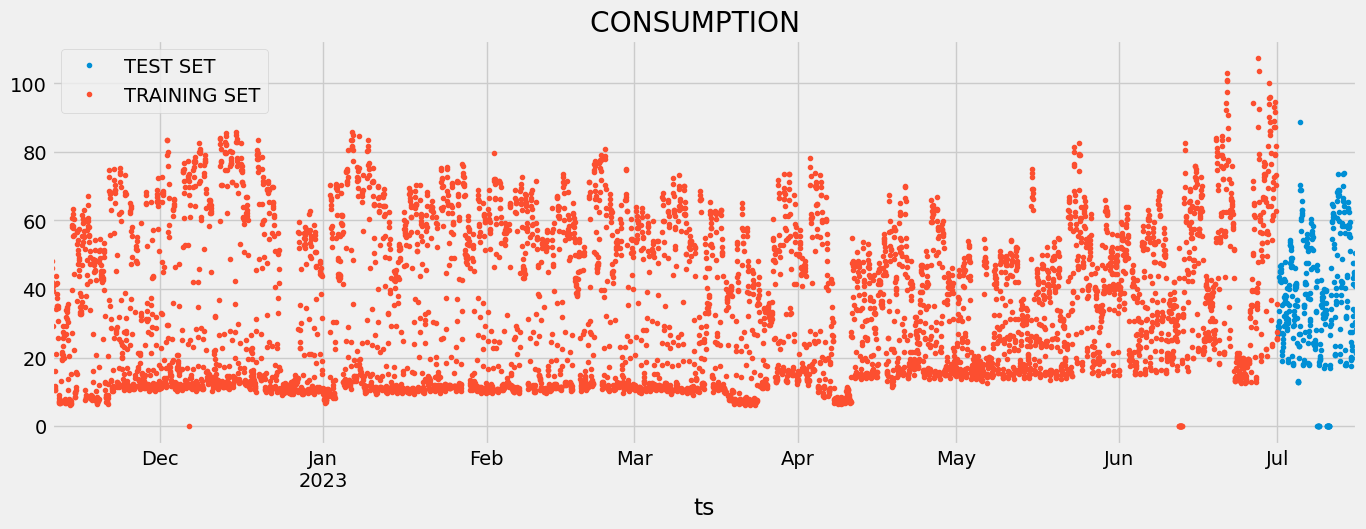

In [ ]:
df_test \
    .rename(columns={'val': 'TEST SET'}) \
    .join(df_train.rename(columns={'val': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='CONSUMPTION  ', style='.');

In [ ]:
def create_features(df, label=None):

    def is_non_working_hour(timestamp):
    # Check if it's a weekend (Saturday or Sunday)
      if timestamp.dayofweek >= 5:
          return 0

      # Check if it's after 18:00 or before 09:00
      if timestamp.hour >= 18 or timestamp.hour < 9:
          return 0

      return 1

    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['working_hour'] = df['date'].apply(is_non_working_hour)
    X = df[['hour', 'dayofweek','month', 'quarter', 'year', 'dayofyear',
            'dayofmonth',"working_hour" ]]

    if label:
        y = df[label]
        return X, y
    return X


In [ ]:
X_train, y_train = create_features(df_train, label='val')
X_test, y_test = create_features(df_test, label='val')

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 50,
        verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

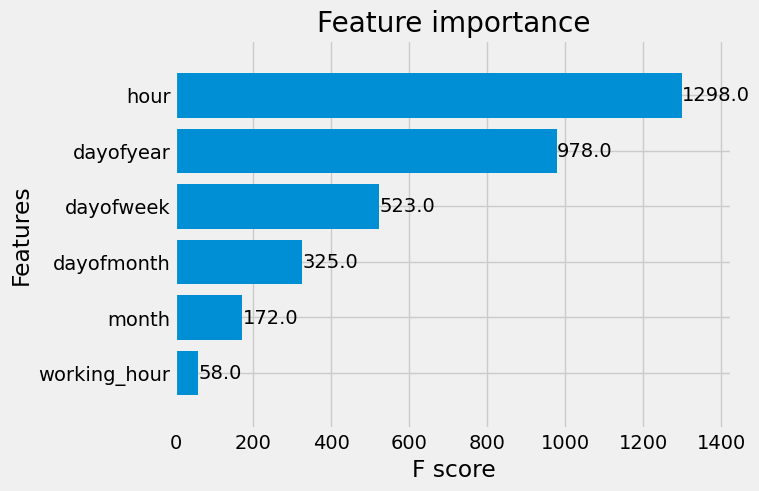

In [ ]:
plot_importance(reg, height=0.8);

In [ ]:
df_test['val_Prediction'] = reg.predict(X_test)

In [ ]:
df_test

,val,date,hour,dayofweek,month,quarter,year,dayofyear,dayofmonth,working_hour,val_Prediction
ts,,,,,,,,,,,
2023-07-01 01:00:00,27.576,2023-07-01 01:00:00,1,5,7,3,2023,182,1,0,20.602081
2023-07-01 02:00:00,26.856,2023-07-01 02:00:00,2,5,7,3,2023,182,1,0,22.472546
2023-07-01 03:00:00,28.200,2023-07-01 03:00:00,3,5,7,3,2023,182,1,0,22.683916
2023-07-01 04:00:00,29.256,2023-07-01 04:00:00,4,5,7,3,2023,182,1,0,22.905617
2023-07-01 05:00:00,28.908,2023-07-01 05:00:00,5,5,7,3,2023,182,1,0,24.323526
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-15 21:00:00,19.968,2023-07-15 21:00:00,21,5,7,3,2023,196,15,0,25.258366
2023-07-15 22:00:00,21.240,2023-07-15 22:00:00,22,5,7,3,2023,196,15,0,23.533632
2023-07-15 23:00:00,21.336,2023-07-15 23:00:00,23,5,7,3,2023,196,15,0,23.131641


In [ ]:
df_all = pd.concat([df_test, df_train], sort = False)

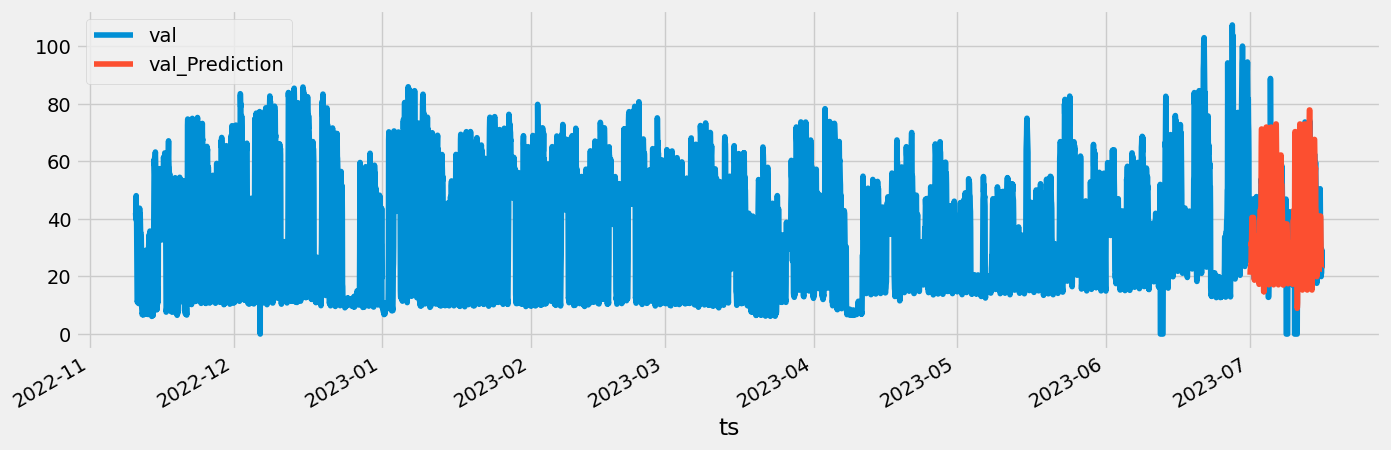

In [ ]:
df_all[['val', 'val_Prediction']].plot(figsize=(15,5));

In [ ]:
X_test

,hour,dayofweek,month,quarter,year,dayofyear,dayofmonth,working_hour
ts,,,,,,,,
2023-07-01 01:00:00,1,5,7,3,2023,182,1,0
2023-07-01 02:00:00,2,5,7,3,2023,182,1,0
2023-07-01 03:00:00,3,5,7,3,2023,182,1,0
2023-07-01 04:00:00,4,5,7,3,2023,182,1,0
2023-07-01 05:00:00,5,5,7,3,2023,182,1,0
...,...,...,...,...,...,...,...,...
2023-07-15 21:00:00,21,5,7,3,2023,196,15,0
2023-07-15 22:00:00,22,5,7,3,2023,196,15,0
2023-07-15 23:00:00,23,5,7,3,2023,196,15,0


In [ ]:
def generate_date_range(start_date, end_date):
    """
    Generate a date range from start_date to end_date.
    """
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    return date_range

# Define the start and end dates
start_date_str = '2023-07-01'
end_date_str = '2024-03-01'

# Convert start_date and end_date strings to datetime objects
start_date = pd.to_datetime(start_date_str)
end_date = pd.to_datetime(end_date_str)

# Generate the date range
date_range = generate_date_range(start_date, end_date)

# Create a pandas DataFrame to store the dataset
dataset = pd.DataFrame({'ts': date_range})

# Print the first few rows of the dataset
print(dataset.tail())

                      ts
5852 2024-02-29 20:00:00
5853 2024-02-29 21:00:00
5854 2024-02-29 22:00:00
5855 2024-02-29 23:00:00
5856 2024-03-01 00:00:00


In [ ]:
dataset.set_index('ts', inplace=True)
dataset=dataset.tz_localize(None)

In [ ]:
dataset = create_features(dataset)

In [ ]:
dataset['val_Prediction'] = reg.predict(dataset)

In [ ]:
monthly_consumption = data.resample('M').sum()

# Print the result
print(monthly_consumption)

                  val
ts                   
2022-11-30  14898.480
2022-12-31  24444.264
2023-01-31  26380.776
2023-02-28  23899.944
2023-03-31  22513.320
2023-04-30  21821.052
2023-05-31  24824.808
2023-06-30  30759.540
2023-07-31  13388.172


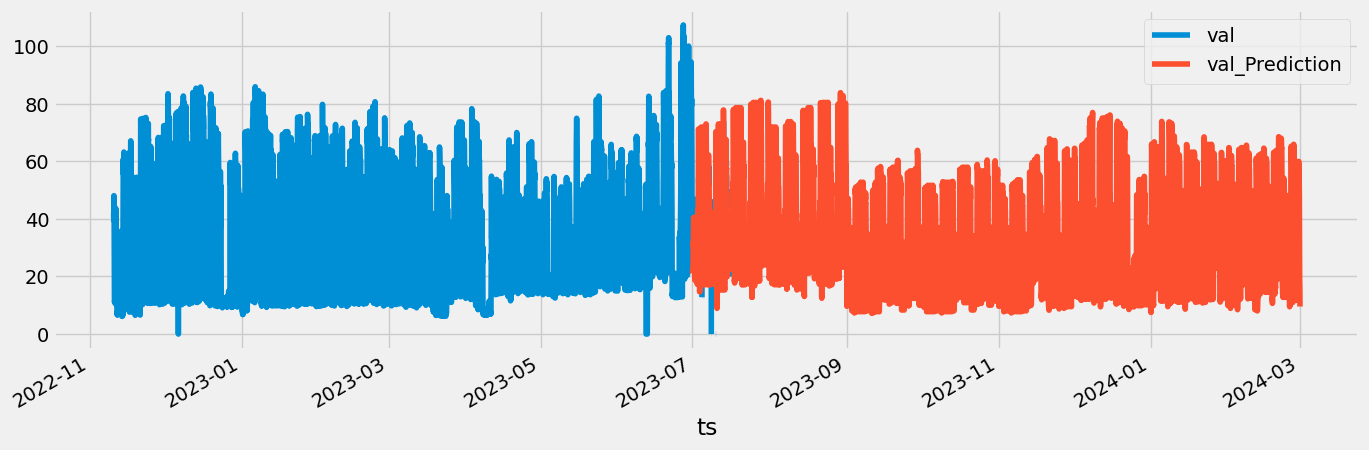

In [ ]:
df_all = pd.concat([df_test, df_train,dataset], sort = False)
df_all[['val', 'val_Prediction']].plot(figsize=(15,5));

In [ ]:
monthly_consumption_predicted = dataset.resample('M').sum()

# Print the result
print(monthly_consumption_predicted)


            hour  dayofweek  month  quarter     year  dayofyear  dayofmonth  \
ts                                                                            
2023-07-31  8556       2280   5208     2232  1505112     146568       11904   
2023-08-31  8556       2160   5952     2232  1505112     169632       11904   
2023-09-30  8280       2232   6480     2160  1456560     186120       11160   
2023-10-31  8556       2184   7440     2976  1505112     215016       11904   
2023-11-30  8280       2136   7920     2880  1456560     230040       11160   
2023-12-31  8556       2376   8928     2976  1505112     260400       11904   
2024-01-31  8556       2088    744      744  1505856      11904       11904   
2024-02-29  8004       2088   1392      696  1408704      32016       10440   
2024-03-31     0          4      3        1     2024         61           1   

            working_hour  val_Prediction  
ts                                        
2023-07-31           189    31762.775391  
2